**Dataset collection**
1. Mount your drive
2. Upload your kaggle.json file (Download your Kaggle API token to get kaggle.json file)
3. Download the dataset (Here, you will get the dataset as imagenet.zip)
Unzip the downloaded dataset

In [ ]:
!kaggle datasets download -d ambityga/imagenet100

Dataset URL: https://www.kaggle.com/datasets/ambityga/imagenet100
License(s): unknown
100% 16.1G/16.1G [02:07<00:00, 145MB/s]
100% 16.1G/16.1G [02:07<00:00, 136MB/s]


In [ ]:
!unzip imagenet100.zip

Streaming output truncated to the last 5000 lines.
  inflating: val.X/n01440764/ILSVRC2012_val_00000293.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00002138.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00003014.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00006697.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00007197.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009111.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009191.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009346.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009379.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009396.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00010306.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00011233.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00011993.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00012503.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00013716.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00016

In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile

<ipython-input-3-36398ed231ac>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
import shutil
for label in os.listdir('/content/val.X'):
    if label in os.listdir('/content/train.X1'):
      label_x=label
      os.makedirs(f'/content/val1/{label_x}')
      print('dir created')
      for filename in os.listdir(f'/content/val.X/{label_x}'):
          shutil.copy(f'/content/val.X/{label_x}/{filename}', f'/content/val1/{label_x}/{filename}')

dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created
dir created


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/train.X1",class_mode= "categorical",target_size=(128,128))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/val1", class_mode= "categorical",target_size=(128,128))

Found 32500 images belonging to 25 classes.
Found 1250 images belonging to 25 classes.


In [ ]:
import tensorflow

choose_model = 'Inceptionv3'

if choose_model == 'VGG16':
  from tensorflow.keras.applications.vgg16 import VGG16

  base_model = VGG16(input_shape = (128, 128, 3), # Shape of our images
  include_top = False, # Leave out the last fully connected layer
  weights = 'imagenet')

elif choose_model == 'Inceptionv3':
  from tensorflow.keras.applications.inception_v3 import InceptionV3

  base_model = InceptionV3(input_shape = (128, 128, 3),
                          include_top = False,
                          weights = 'imagenet')

elif choose_model == 'ResNet50':
  from tensorflow.keras.applications import ResNet50

  base_model = InceptionV3(input_shape = (128, 128, 3),
                          include_top = False,
                          weights = 'imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Implementation of RandomSearch Algorithm

In [ ]:
def model(hp):

  x = Flatten()(base_model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = Dense(hp.Choice('unit',[512,1024]), activation=hp.Choice('activation',['relu','tanh']))(x)

  # Add a dropout rate of 0.5
  x = Dropout(hp.Choice('drop',[0.2,0.5]))(x)

  # Add a final sigmoid layer with 1 node for classification output
  x = Dense(25, activation='softmax')(x)

  model = tf.keras.models.Model(base_model.input, x)
  hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'])

  if hp_optimizer == 'sgd':
      optimizer = tf.keras.optimizers.SGD(hp.Choice('lr',values=[1e-2,1e-4]))
  elif hp_optimizer == 'rmsprop':
      optimizer = tf.keras.optimizers.RMSprop(hp.Choice('lr',values=[1e-2,1e-4]))
  else:
      optimizer = tf.keras.optimizers.Adam(hp.Choice('lr',values=[1e-2,1e-4]))
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['acc'])
  return model

In [ ]:
!pip install keras-tuner
import keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner
tuner = keras_tuner.RandomSearch(
    model,
    objective='val_acc',
    max_trials=3)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
unit (Choice)
{'default': 512, 'conditions': [], 'values': [512, 1024], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
drop (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'rmsprop', 'adam'], 'ordered': False}
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
tuner.search(traindata,epochs=3,validation_data=testdata)
best_model = tuner.get_best_models()[0]

In [ ]:
tuner.results_summary()

Tuning the hyperparameters, based on the results obtained from above.

The results are as:

1. Units - 1024
2. Activation - Relu
3. Drop - 0.2
4. Optimizer - Adam
5. Learning rate - e^-4

In [ ]:
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(25, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy',metrics = ['acc'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("Model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit(traindata, validation_data= testdata,epochs=2,callbacks=[checkpoint,early])

Epoch 1/2
1016/1016 [==============================] - ETA: 0s - loss: 2.6640 - acc: 0.2026
Epoch 1: val_acc improved from -inf to 0.23280, saving model to Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1016/1016 [==============================] - 242s 194ms/step - loss: 2.6640 - acc: 0.2026 - val_loss: 2.5474 - val_acc: 0.2328
Epoch 2/2
1016/1016 [==============================] - ETA: 0s - loss: 2.0290 - acc: 0.3761
Epoch 2: val_acc improved from 0.23280 to 0.26640, saving model to Model.h5
1016/1016 [==============================] - 175s 172ms/step - loss: 2.0290 - acc: 0.3761 - val_loss: 2.5122 - val_acc: 0.2664


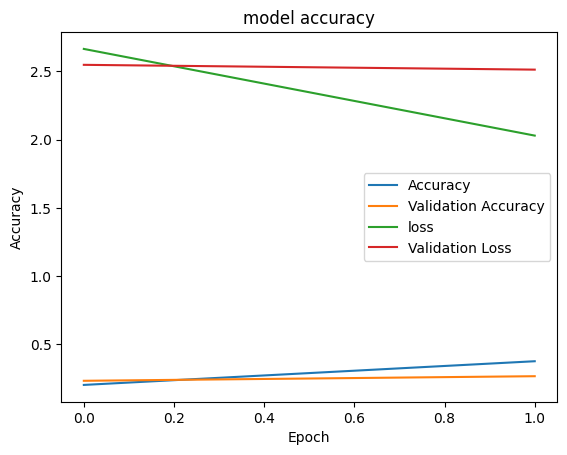

In [ ]:
#Graph to check loss and accuracy

import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
# Precision, recall, f1 score
Y_pred = model.predict(testdata, testdata.samples / 32)
val_preds = np.argmax(Y_pred, axis=1)
import sklearn.metrics as metrics
val_trues =testdata.classes
from sklearn.metrics import classification_report
print(classification_report(val_trues, val_preds))

40/40 [==============================] - 9s 174ms/step
              precision    recall  f1-score   support

           0       0.04      0.02      0.03        50
           1       0.25      0.02      0.04        50
           2       0.04      0.04      0.04        50
           3       0.00      0.00      0.00        50
           4       0.08      0.04      0.05        50
           5       0.00      0.00      0.00        50
           6       0.03      0.04      0.03        50
           7       0.00      0.00      0.00        50
           8       0.03      0.10      0.05        50
           9       0.04      0.04      0.04        50
          10       0.02      0.02      0.02        50
          11       0.00      0.00      0.00        50
          12       0.00      0.00      0.00        50
          13       0.02      0.02      0.02        50
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        50
          16       0.03   

In [ ]:
Y_pred = model.predict(testdata, testdata.samples / 32)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =testdata.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

40/40 [==============================] - 5s 118ms/step


array([[ 3,  0,  0,  0,  0,  3,  1,  1,  7,  3,  0,  0,  0,  1,  0,  0,
         8,  2,  3,  7,  7,  0,  1,  2,  1],
       [ 1,  0,  4,  0,  2,  0,  3,  0,  6,  1,  0,  0,  1,  0,  0,  0,
        10,  2,  1,  5,  7,  0,  0,  3,  4],
       [ 0,  0,  2,  0,  0,  1,  5,  1,  6,  3,  3,  0,  1,  3,  0,  2,
         8,  1,  0,  2,  7,  0,  0,  2,  3],
       [ 3,  0,  5,  0,  0,  0,  1,  0,  8,  2,  1,  1,  1,  2,  0,  0,
        11,  4,  1,  5,  2,  2,  0,  0,  1],
       [ 1,  0,  3,  2,  0,  2,  1,  0,  3,  4,  1,  2,  2,  3,  3,  2,
         8,  2,  0,  2,  4,  1,  0,  1,  3],
       [ 1,  0,  0,  2,  2,  1,  4,  1,  6,  0,  0,  0,  0,  3,  1,  3,
        10,  1,  2,  3,  9,  0,  0,  0,  1],
       [ 1,  0,  2,  1,  1,  4,  5,  0, 10,  2,  3,  0,  0,  0,  0,  4,
         3,  1,  1,  4,  3,  0,  0,  3,  2],
       [ 2,  0,  2,  1,  0,  2,  0,  0,  7,  1,  1,  0,  1,  6,  1,  3,
         8,  2,  2,  1,  6,  1,  1,  1,  1],
       [ 0,  0,  1,  0,  0,  1,  2,  0,  7,  3,  2,  0,  0,  1, 